In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch.utils.data import DataLoader
import yaml

from train import get_dataset, get_model
from utils import setup_seed

/home/zhouziyang/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1D example: 1D Advection Equation

### Prepare data and load trained model 

In [2]:
# config
config_path = "configs/config_1D_Advection.yaml"
with open(config_path, 'r') as f:
    args = yaml.safe_load(f)
setup_seed(args['seed'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data
train_data, val_data = get_dataset(args) # get dataset
dataloader = DataLoader(val_data, batch_size=1, shuffle=False) # set batch_size=1 and shuffle=False
x, y = next(iter(dataloader)) # get test sample

# model
spatial_dim = len(x.shape) - 3
model = get_model(spatial_dim, args) 

# load trained model weights
checkpoint = torch.load(args["model_path"]) # make sure args["model_path"] is absolute path
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

# set other args
initial_step = args['initial_step']

UNetDatasetSingle


### Infer

In [3]:
# goal: get data to visualize (reuse code of test_loop)
model.eval()
x = x.to(device)
y = y.to(device)
pred = y[..., :initial_step, :]
input_shape = list(x.shape)[:-2]
input_shape.append(-1) # (bs, x1, ..., xd, -1)
for t in range(initial_step, y.shape[-2]):
    model_input = x.reshape(input_shape)
    input_permute = [0, -1]
    input_permute.extend([i for i in range(1, len(model_input.shape)-1)])
    model_input = model_input.permute(input_permute)
    output_permute = [0]
    output_permute.extend([i for i in range(2, len(model_input.shape))]) 
    output_permute.append(1)
    with torch.no_grad():
        model_output = model(model_input).permute(output_permute).unsqueeze(-2)
    pred = torch.cat((pred, model_output), dim=-2)
    x = torch.cat((x[..., 1:, :], model_output), dim=-2)

# reshape tensor into (t, x, c) format and convert to numpy array
data_to_visualize = pred.squeeze(0).permute([1, 0, 2]).cpu() # (t, x, c)
data_to_visualize = np.array(data_to_visualize, dtype=np.float32)

# residual or error
residual_to_visualize = (pred - y).squeeze(0).permute([1, 0, 2]).cpu()
residual_to_visualize = np.array(residual_to_visualize, dtype=np.float32)

# ground truth
gt_to_visualize = y.squeeze(0).permute([1, 0, 2]).cpu()
gt_to_visualize = np.array(gt_to_visualize, dtype=np.float32)

### Load coordinate from dataset file

In [4]:
# goal: get x-coordinate and t-coordinate
with h5py.File(os.path.join(args['dataset']['saved_folder'], args['dataset']['file_name']), 'r') as f:
    xcrd = np.array(f['x-coordinate'], dtype=np.float32)
    tcrd = np.array(f['t-coordinate'], dtype=np.float32)
xcrd = xcrd[::args['dataset']['reduced_resolution']]
tcrd = tcrd[::args['dataset']['reduced_resolution_t']]

# trim coordinates
nt, nx = data_to_visualize.shape[0], data_to_visualize.shape[1]
if xcrd.shape[0] > nx:
    xcrd = xcrd[:nx]
if tcrd.shape[0] > nt:
    tcrd = tcrd[:nt]

### Visualize infered solution with plot

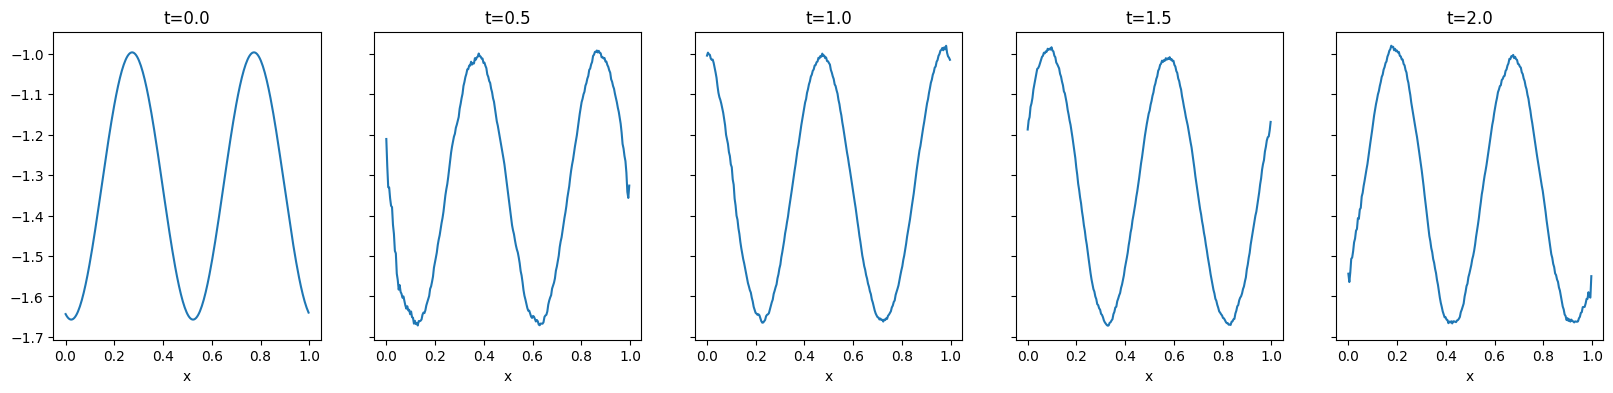

In [5]:
num_cols = 5
fig, ax = plt.subplots(1, num_cols, sharex=True, sharey=True, figsize=(num_cols*4, 4))
step = int(tcrd.shape[0] / (num_cols - 1))
for i in range(num_cols):
    t = int(step*i)
    ax[i].plot(xcrd, data_to_visualize[t].squeeze())
    ax[i].set_xlabel("x")
    ax[i].set_title(f"t={tcrd[t]}")
plt.show()

### Visualize infered solution with color map

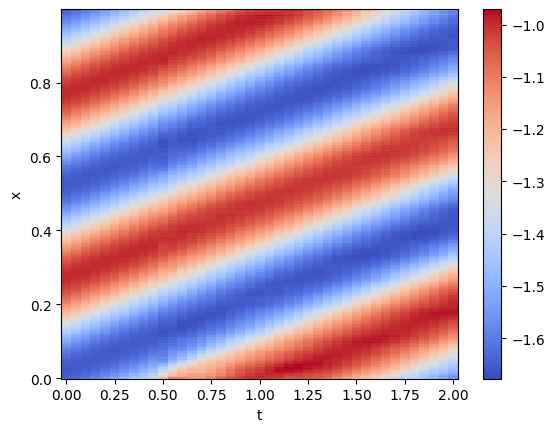

In [6]:
fig, ax = plt.subplots()
X, Y = np.meshgrid(tcrd, xcrd)
pc = ax.pcolormesh(X, Y, data_to_visualize.squeeze().T, cmap='coolwarm')
fig.colorbar(pc)
ax.set_xlabel("t")
ax.set_ylabel("x")
plt.show()

### Visualize error with color map 

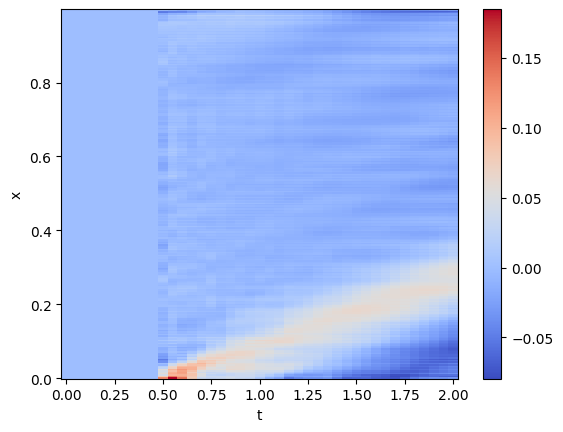

In [7]:
fig, ax = plt.subplots()
X, Y = np.meshgrid(tcrd, xcrd)
pc = ax.pcolormesh(X, Y, residual_to_visualize.squeeze().T, cmap='coolwarm')
fig.colorbar(pc)
ax.set_xlabel("t")
ax.set_ylabel("x")
plt.show()

### Visualize comparision between infered solution and groud truth with plot

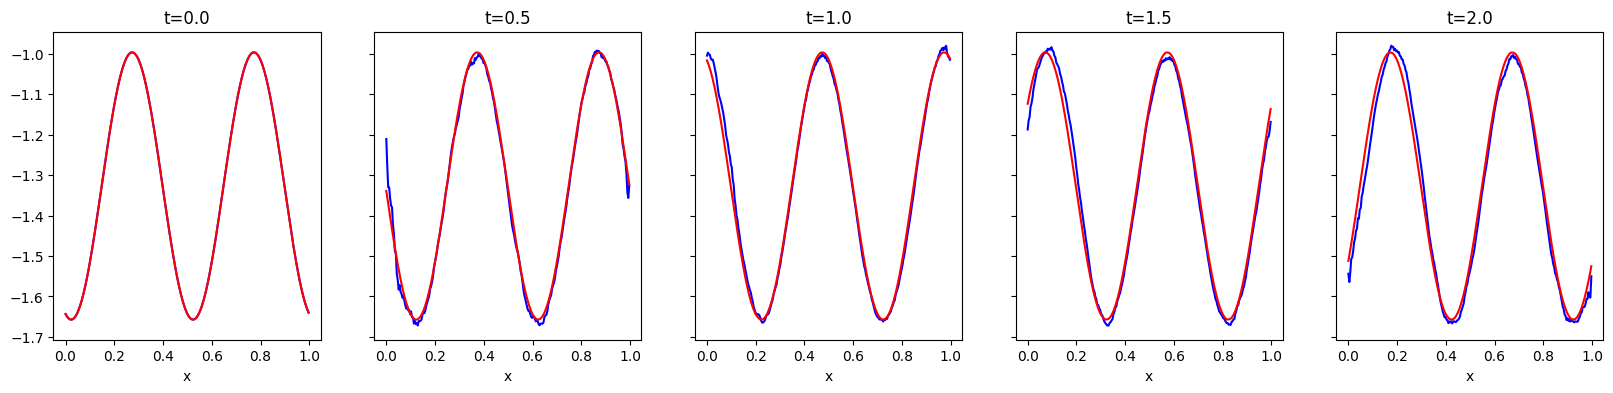

In [8]:
num_cols = 5
fig, ax = plt.subplots(1, num_cols, sharex=True, sharey=True, figsize=(num_cols*4, 4))
step = int(tcrd.shape[0] / (num_cols - 1))
for i in range(num_cols):
    t = int(step*i)
    ax[i].plot(xcrd, data_to_visualize[t].squeeze(), color='blue') # blue: predicted solution
    ax[i].plot(xcrd, gt_to_visualize[t].squeeze(), color='red') # red: ground truth
    ax[i].set_xlabel("x")
    ax[i].set_title(f"t={tcrd[t]}")
plt.show()

### Visualize MSE at each time step

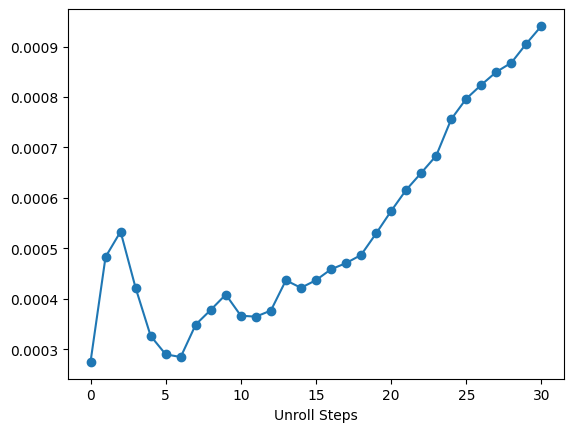

In [9]:
fig, ax = plt.subplots()
nt = residual_to_visualize.shape[0]
time_step = []
MSEs = []
for i in range(initial_step, nt):
    time_step.append(i)
    MSEs.append(np.mean(np.power(residual_to_visualize[i].ravel(), 2)))
time_step = [(t - initial_step) for t in time_step]
ax.plot(time_step, MSEs, marker='o')
ax.set_xlabel("Unroll Steps")
plt.show()